In [1]:
%matplotlib inline

In [2]:
try:
    import pennylane as qml
except ImportError:
    print("installing pennylane...")
    !pip install --quiet pennylane
    print("installed pennylane.")
    import pennylane as qml

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from itertools import product, combinations, permutations
from dataclasses import dataclass

import numpy as np
np.set_printoptions(suppress=True)

import scipy.special as sp

# Holonomic quantum computation

This project aims to implement the Holonomic quantum gates proposal by Chunfeng Wu, Yimin Wang, Xun-Li Feng, and Jing-Ling Chen in https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.014055. 

Ever since the first proposals of quantum protocols (communication and encryption protocols, teleportation, and others), it was clear that environmental effects would affect their correct execution. Over the years several proposals have been made to mitigate this obstacle, from sophisticated quantum control schemes to the construction of robust topological structures. This proposal is encapsulated in the latter. 

The topological characters present in the system's parameter space have found several applications. Namely, the toric code by Kitaev proved to be a strong enough concept to inspire a large amount of research.

This work explores the implementation of a 3-qubit Hamiltonian capable of implementing single-qubit and two-qubit quantum gates with inherited decoherence protection in the context of a surface code. The idea is to implement the quantum circuit that defines the latter in terms of holonomic gates.

Firstly, we implement a standard surface code. Then, using Pennylane's ApproxTimeEvolution function, we perform a discrete implementation of the so-mentioned Hamiltonian that turns out to be equivalent to the implementation of certain quantum gates depending on the set of Hamiltonian parameters chosen.

# Surface code

The following implementation follows the Surface code description from https://arxiv.org/ftp/arxiv/papers/1208/1208.0928.pdf

In [4]:
@dataclass(frozen=True)
class Wire:
    layer: int
    i: int
    j: int

### Raw lattice definition

Our objective if to implement the following lattice of qubits

<img src="figures/surface.png" width="500" height="250">

where the solid qubits are called data-qubits, and the hollow-qubits correpond to x and z-measurement qubits

In [5]:
## lattice dimensions

## Qubit array layers
n_qubit_layers = 3 # | 0: Surface code | 1: type-I auxiliar qubits | 2: type-II auxiliar qubits |

## surface code sites.  Min size 2 x 2
nx = 3
ny = 3
surface_code_all_sites = [(0, px, py) for px, py in product(range(nx), range(ny))]
 
## type-I auxiliar qubits sites
nx_I = nx - 1
ny_I = ny - 1
type_I_all_sites = [(1, px, py) for px, py in product(range(nx_I), range(ny_I))]

## type-II auxiliar qubits sites
nx_II = nx_I
ny_II = ny // 2
type_II_all_sites = [(2, px, py) for px, py in product(range(nx_II), range(ny_II))]

## raw qubit lattice 
#dev = qml.device("lightning.qubit", wires=[Wire(*s) for s in surface_code_all_sites]) # debug
dev = qml.device("lightning.qubit", wires=[Wire(*s) for s in surface_code_all_sites + type_I_all_sites + type_II_all_sites])

### Data qubits

In [6]:
## Data qubits
data_sites = []

for l, x, y in surface_code_all_sites + type_I_all_sites + type_II_all_sites:
    x0 = 2*x
    y0 = 2*y

    data_a_site = (0, x0, y0)
    data_b_site = (0, x0 + 1, y0 +1)

    if (data_a_site[1] < nx) and (data_a_site[2] < ny):
        data_sites.append(data_a_site)
        
    if (data_b_site[1] < nx) and (data_b_site[2] < ny):
        data_sites.append(data_b_site)

In [7]:
data_sites

[(0, 0, 0),
 (0, 1, 1),
 (0, 0, 2),
 (0, 2, 0),
 (0, 2, 2),
 (0, 0, 0),
 (0, 1, 1),
 (0, 0, 2),
 (0, 2, 0),
 (0, 2, 2),
 (0, 0, 0),
 (0, 1, 1),
 (0, 2, 0)]

### X-measurement qubits

In [8]:
## X measurement sites and operators
x_measure_sites = []
x_measure_data_sites = [] 
x_op = []

for x, y in product(range(nx // 2 + nx % 2), range(ny // 2 + ny % 2)):
    x0 = 2 * x
    y0 = 2 * y + 1

    sites = []
    for px, py in [(x0 - 1, y0), (x0, y0 - 1), (x0 + 1, y0), (x0, y0 + 1)]:
        if ((px >= 0) and (py >= 0)) and ((px < nx) and (py < ny)):
            sites.append((0, px, py))
            
    op = qml.operation.Tensor(*(qml.PauliX(Wire(*s)) for s in sites))

    x_measure_sites.append((0, x0, y0))
    x_measure_data_sites.append(sites)
    x_op.append(op)

In [9]:
x_measure_sites

[(0, 0, 1), (0, 0, 3), (0, 2, 1), (0, 2, 3)]

### Z-measurement qubits

In [10]:
## Z measurement sites and operators
z_measure_sites = []
z_measure_data_sites = [] 
z_op = []

for x, y in product(range(nx // 2 + nx % 2), range(ny // 2 + ny % 2)):
    x0 = 2 * x + 1
    y0 = 2 * y 
    
    sites = []
    for px, py in [(x0 - 1, y0), (x0, y0 - 1), (x0 + 1, y0), (x0, y0 + 1)]:
        if ((px >= 0) and (py >= 0)) and ((px < nx) and (py < ny)):
            sites.append((0, px, py))
            
    op = qml.operation.Tensor(*(qml.PauliZ(Wire(*s)) for s in sites))

    z_measure_sites.append((0, x0, y0))
    z_measure_data_sites.append(sites)
    z_op.append(op)

In [11]:
z_measure_sites

[(0, 1, 0), (0, 1, 2), (0, 3, 0), (0, 3, 2)]

## Code cycle
### Random initial state for the data qubits

In [12]:
from scipy.stats import rv_continuous

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)

# Samples of theta should be drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary(layer, sx, sy):
    phi, omega = 2 * np.pi * np.random.uniform(size=2) # Sample phi and omega as normal
    theta = sin_sampler.rvs(size=1) # Sample theta from our new distribution
    qml.Rot(phi, theta, omega, wires=Wire(layer, sx, sy))
    return qml.state()

for site in data_sites:
    haar_random_unitary(*site)

@qml.qnode(dev)
def state():
    return qml.state()

### Surface code implementation

The surface code implementation schemes follows the following logic

<img src="figures/circuit.png" width="400" height="200">

Where this code is equivalent to this section of the latice

<img src="figures/circuit_2.png" width="150" height="75">

In [13]:
@qml.qnode(dev)
def surface_code():
    ## measurement qubits init
    ### x-syndrome initial Hadamard and x-controlled CNOT      
    for n_site, x_m_site in enumerate(x_measure_sites):
        qml.Hadamard(Wire(*x_m_site))
        op = x_op[n_site]
        for target in op.wires:
            qml.CNOT(wires=[Wire(*x_m_site), target])

    ### z-target CNOT
    for n_site, z_m_site in enumerate(z_measure_sites):
        op = z_op[n_site]
        for target in op.wires:
            qml.CNOT(wires=[target, Wire(*z_m_site)])

    ### x-syndrome final Hadamard  
    for x_m_site in x_measure_sites:
        qml.Hadamard(Wire(*x_m_site))

    return qml.state()

In [14]:
print(qml.draw(surface_code)())

Wire(layer=0, i=0, j=0): ────╭X──────────╭●───────────────────────────────┤  State
Wire(layer=0, i=0, j=1): ──H─╰●─╭●─╭●────│───H────────────────────────────┤  State
Wire(layer=0, i=0, j=2): ───────│──╰X─╭X─│──────────────╭●────────────────┤  State
Wire(layer=0, i=1, j=0): ───────│─────│──╰X───────╭X─╭X─│─────────────────┤  State
Wire(layer=0, i=1, j=1): ───────╰X────│─────╭X────│──╰●─│──╭●─────────────┤  State
Wire(layer=0, i=1, j=2): ─────────────│─────│─────│─────╰X─╰X─╭X──────────┤  State
Wire(layer=0, i=2, j=0): ─────────────│─────│──╭X─╰●──────────│──╭●───────┤  State
Wire(layer=0, i=2, j=1): ─────────────│───H─╰●─╰●─╭●──────────│──│───H────┤  State
Wire(layer=0, i=2, j=2): ─────────────│───────────╰X─╭X───────╰●─│──╭●────┤  State
Wire(layer=0, i=0, j=3): ──H──────────╰●─────────────│───────────│──│───H─┤  State
Wire(layer=0, i=2, j=3): ──H─────────────────────────╰●──────────│──│───H─┤  State
Wire(layer=0, i=3, j=0): ────────────────────────────────────────╰X─│─────┤  State
Wire

# Holonomic gate implementation
Holomonic gates based on https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.014055

The execution of the code requires the addition of two types of auxiliar qubits: type-I qubits (solid orange), and type-II qubits (hollow orange). Each auxiliar qubit is coupled to the data and measurement qubit in the following way

<img src="figures/aux_1.png" width="150" height="75">

<img src="figures/aux_2.png" width="150" height="75">

To perform this coupling we define groups of 4 data and measurement qubit and 2 auxiliar qubits called 'plaquettes'

**Following the paper mentioned above, we define each plaquette as the meeting of 4 qubits organized as follows:**

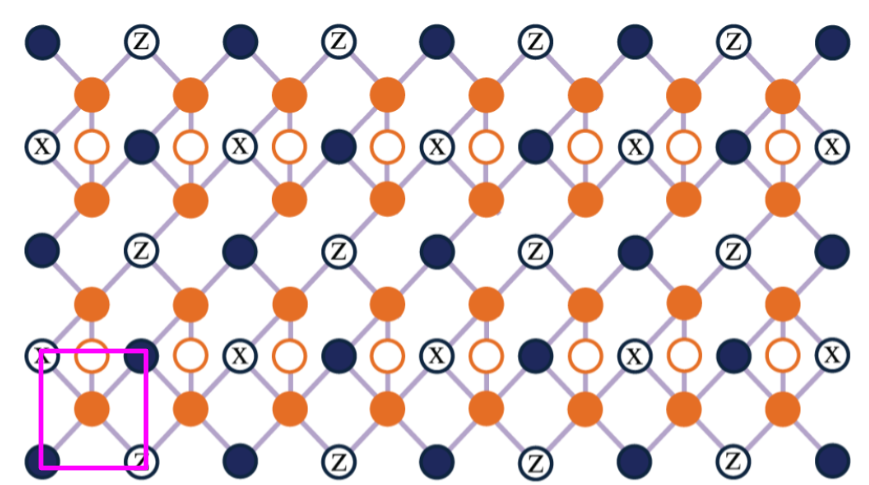

In [15]:
## Plaquette definition
keys_vals_single = []
keys_vals_pairs = []
plaquette_num = 0
for py in range(ny // 2 + ny % 2):
  for px in range(nx // 2 + nx % 2):

    plaquette_sites = [(0, px, py), (0, px + 1, py), (0, px, py + 1), (0, px + 1, py + 1)]
    sites_pairs = list(combinations(plaquette_sites, 2))

    keys_vals_single += [((p), plaquette_num) for p in plaquette_sites]
    keys_vals_pairs += [((p_1, p_2), plaquette_num) for p_1, p_2 in sites_pairs]

    ## update plaquette num
    plaquette_num += 1

## plaquette number assignation
dict_single_plaquette = {key : val for key, val in keys_vals_single}
dict_pairs_plaquette = {key : val for key, val in keys_vals_pairs}

**We then name each platelet where the value indicates what it is and the key indicates the qubits belonging to said plaquette.**

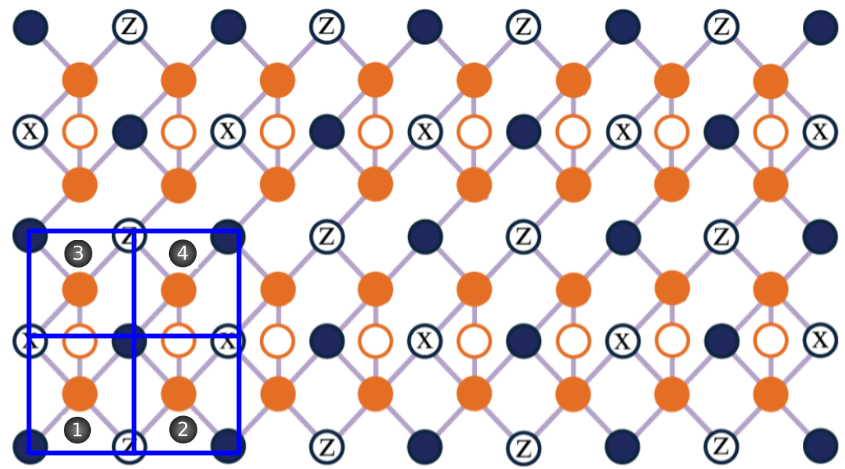

In [16]:
dict_single_plaquette

{(0, 0, 0): 0,
 (0, 1, 0): 1,
 (0, 0, 1): 2,
 (0, 1, 1): 3,
 (0, 2, 0): 1,
 (0, 2, 1): 3,
 (0, 0, 2): 2,
 (0, 1, 2): 3,
 (0, 2, 2): 3}

**For each plaquette, two pairs of qubits defined in the following dictionary are associated:**

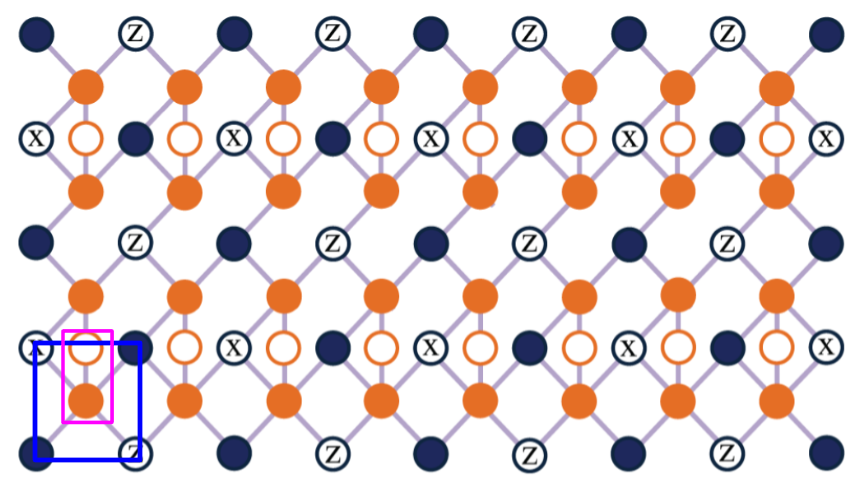

In [17]:
dict_pairs_plaquette

{((0, 0, 0), (0, 1, 0)): 0,
 ((0, 0, 0), (0, 0, 1)): 0,
 ((0, 0, 0), (0, 1, 1)): 0,
 ((0, 1, 0), (0, 0, 1)): 0,
 ((0, 1, 0), (0, 1, 1)): 1,
 ((0, 0, 1), (0, 1, 1)): 2,
 ((0, 1, 0), (0, 2, 0)): 1,
 ((0, 1, 0), (0, 2, 1)): 1,
 ((0, 2, 0), (0, 1, 1)): 1,
 ((0, 2, 0), (0, 2, 1)): 1,
 ((0, 1, 1), (0, 2, 1)): 3,
 ((0, 0, 1), (0, 0, 2)): 2,
 ((0, 0, 1), (0, 1, 2)): 2,
 ((0, 1, 1), (0, 0, 2)): 2,
 ((0, 1, 1), (0, 1, 2)): 3,
 ((0, 0, 2), (0, 1, 2)): 2,
 ((0, 1, 1), (0, 2, 2)): 3,
 ((0, 2, 1), (0, 1, 2)): 3,
 ((0, 2, 1), (0, 2, 2)): 3,
 ((0, 1, 2), (0, 2, 2)): 3}

In [18]:
## Auxiliar qubits per plaquette
keys_vals = []
plaquette_num = 0
for py_I in range(ny_I):
  for px_I in range(nx_I):

    px_II = px_I
    py_II = py_I // 2

    type_I_qubit = (1, px_I, py_I)
    type_II_qubit = (2, px_II, py_II)

    keys_vals += [((type_I_qubit, type_II_qubit), plaquette_num)]

    ## update plaquette num
    plaquette_num += 1

## plaquette auxiliar qubits number assignation
dict_aux_qubit_plaquette = {val : key for key, val in keys_vals}

In [19]:
dict_aux_qubit_plaquette

{0: ((1, 0, 0), (2, 0, 0)),
 1: ((1, 1, 0), (2, 1, 0)),
 2: ((1, 0, 1), (2, 0, 0)),
 3: ((1, 1, 1), (2, 1, 0))}

**This plaquette assignation allows us to easily implement the Hamiltonian to the desired qubit or pair of qubits

### Single qubit gate

The Hamiltonian is given by

<img src="figures/hamil.png" width="300" height="200">

Where the index 1, 2, A indicates the qubit label. The qubit gate depends on the set of parameters chosen.

### Hamiltonian parameters

In [20]:
def hamiltonian_coeff(theta, psi):
  ## ********************************************
  epsilon_A = 2 * np.pi * 8e9
  epsilon_prime_1 = 2 * epsilon_A
  epsilon_prime_2 = epsilon_A

  omega_A = epsilon_A
  eta_A = 0.8 * omega_A

  JA1 = 0.008 * epsilon_prime_1
  JA2 = 0

  Delta_A = 2 * JA1 * np.cos(theta)
  phi_A = -.5 * np.pi - psi
  ## ********************************************
  alpha = 1.1

  J = JA1 * np.sin(theta) * sp.j1(-alpha)
  Delta = JA1 * np.cos(theta) * sp.j1(alpha)

  Omega = np.sqrt(J**2 + 4*Delta**2)
  ## ********************************************
  time = np.pi / Omega
  ## ********************************************
  coef = [.5*epsilon_prime_1, 
          .5*epsilon_prime_2, 
          .5*epsilon_A, 
          .5*Delta_A, 
          JA1*np.sin(theta), 
          -JA1*np.cos(theta), 
          JA2*np.sin(theta), 
          -JA2*np.cos(theta), 
          .5*eta_A*np.sin(time*omega_A + phi_A)]

  print(f'nu: {2 * np.arctan(J/(2 * Delta))}')
  return coef, time

### Single-qubit holonomic gate

In [21]:
@qml.qnode(dev)
def holonomic_single_qubit_gate(site, theta, psi):
  
  plaquette = dict_single_plaquette[site]

  aux_type_I, aux_type_II = dict_aux_qubit_plaquette[plaquette]

  obs = [ qml.PauliZ(Wire(*site)),
          qml.PauliZ(Wire(*site)),
          qml.PauliZ(Wire(*aux_type_I)),
          qml.PauliX(Wire(*aux_type_I)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliX(Wire(*site)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliZ(Wire(*site)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliX(Wire(*site)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliZ(Wire(*site)),
          qml.PauliZ(Wire(*aux_type_I))]

  coef, time = hamiltonian_coeff(theta, psi)
  single_gate_hamiltonian = qml.Hamiltonian(coef, obs)

  qml.ApproxTimeEvolution(single_gate_hamiltonian, time, 1)

  return qml.state()


@qml.qnode(dev)
def holonomic_two_qubit_gate(site_1, site_2, theta, psi):
  try:
    plaquette = dict_pairs_plaquette[(site_1, site_2)]
  except:
    plaquette = dict_pairs_plaquette[(site_2, site_1)]

  aux_type_I, aux_type_II = dict_aux_qubit_plaquette[plaquette]

  obs = [ qml.PauliZ(Wire(*site_1)),
          qml.PauliZ(Wire(*site_2)),
          qml.PauliZ(Wire(*aux_type_I)),
          qml.PauliX(Wire(*aux_type_I)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliX(Wire(*site_1)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliZ(Wire(*site_1)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliX(Wire(*site_2)),
          qml.PauliX(Wire(*aux_type_I)) @ qml.PauliZ(Wire(*site_2)),
          qml.PauliZ(Wire(*aux_type_I))]

  coef, time = hamiltonian_coeff(theta, psi)
  single_gate_hamiltonian = qml.Hamiltonian(coef, obs)

  qml.ApproxTimeEvolution(single_gate_hamiltonian, time, 1)

  return qml.state()

### Fidelity comparison

Finally we compare the analitical single-gate action with the holonomic implementation via the fidelity

In [22]:
qubit_a = (0, 0, 0)

# # Pauli X
# aux_state = holonomic_single_qubit_gate(qubit_a, np.arctan(2), 0)

# Pauli Y
aux_state = holonomic_single_qubit_gate(qubit_a, -np.arctan(2), .25*np.pi)

# # Pauli Z
# aux_state = holonomic_single_qubit_gate(qubit_a, 0, 0)

@qml.qnode(dev)
def test_func():
    # # Pauli X
    # qml.PauliX(wires=Wire(*qubit_a))

    # Pauli Y
    qml.PauliY(wires=Wire(*qubit_a))
    
    # # Pauli Z
    # qml.PauliZ(wires=Wire(*qubit_a))
    
    return qml.state()

print(f'Fidelity: {np.linalg.norm(np.dot(test_func(), np.conjugate(aux_state)))**2}')

nu: 1.5707963267948963
Fidelity: 0.9999495028797264
